In [1]:
import os
import requests

In [2]:
DATA_DIR = "data"
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
URLS = {
    'KDDTrain+.txt':'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt',
    'KDDTest+.txt' : 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt'
}

def download_file(url,filename):
    local_path = os.path.join(DATA_DIR, filename)

    if os.path.exists(local_path):
        print(f"Correct file found: {filename} already exists")
        return
    print(f"Downloading {filename}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(local_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size = 8000):
                f.write(chunk)
        print(f"Success saved to {local_path}")
    except Exception as e:
        print(f"Failed to download {filename} :{e}")

In [3]:
for filename, url in URLS.items():
    download_file(url,filename)
print("\nAll files should now be in 'data' folder.")

Success saved to data/KDDTrain+.txt
Success saved to data/KDDTest+.txt

All files should now be in 'data' folder.


In [4]:
# Step:0 import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [5]:
import pandas as pd

#Step1:Load Provide Dataset, Column names from NSL-KDD (full list)
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
    'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
    'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
    'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
    'dst_host_srv_rerror_rate','attack_type','level'
]

train_path = os.path.join(DATA_DIR, 'KDDTrain+.txt')
test_path = os.path.join(DATA_DIR, 'KDDTest+.txt')

# Read CSV with our column names
train_df = pd.read_csv(train_path, names=columns)
test_df = pd.read_csv(test_path, names=columns)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Train shape: (125973, 43)
Test shape: (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [6]:
#Step 2:Slice Data(TCP Traffic,Normal/DOS) before tht we will check what are the unique attack types in the training data
attack_counts=train_df['attack_type'].value_counts()
print("Attack type counts:\n",attack_counts)

Attack type counts:
 attack_type
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


In [7]:
#to make it easier of ML,we can create a new column attack_category
def categorize_attack(x):
    if x=='normal':
        return 'normal'
    elif x in['neptune','smurf','back','teardrop','pod','land']:
        return 'dos'
    elif x in ['satan','ipsweep','portsweep','nmap']:
        return 'probe' #scanning attacks
    elif x in ['guess_passwd','ftp_write','warezclient','warezmaster','phf','multihop','imap','spy','perl']:
        return 'r2l'  #Remote to Local
    elif x in ['buffer_overflow','loadmodule','rootkit']:
        return 'u2r' #User to Root
    else:
        return 'other'

train_df['attack_category'] = train_df['attack_type'].apply(categorize_attack)
test_df['attack_category'] = test_df['attack_type'].apply(categorize_attack)
print(train_df['attack_category'].value_counts())

attack_category
normal    67343
dos       45927
probe     11656
r2l         998
u2r          49
Name: count, dtype: int64


Protocol vs Attack Category:
 attack_category    dos  normal
protocol_type                 
0                42188   53600


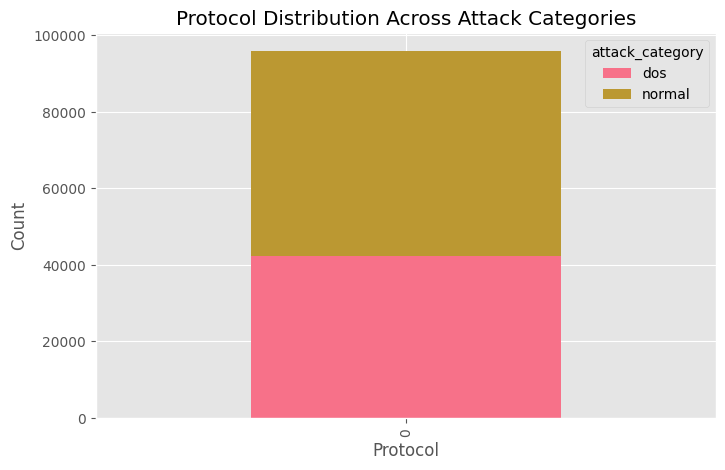

In [45]:
# ===============================
# My Exploration — Protocol vs Attack Category
# ===============================

proto_attack = pd.crosstab(train_df['protocol_type'], train_df['attack_category'])

print("Protocol vs Attack Category:\n", proto_attack)

proto_attack.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title("Protocol Distribution Across Attack Categories")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.show()

In [8]:
# Step 3: Keep only TCP traffic
tcp_train = train_df[train_df['protocol_type'] == 'tcp']
tcp_test = test_df[test_df['protocol_type'] == 'tcp']

# Step 4: Binary classification: normal vs DOS attacks
binary_train = tcp_train[tcp_train['attack_category'].isin(['normal','dos'])]
binary_test = tcp_test[tcp_test['attack_category'].isin(['normal','dos'])]

# Quick check
print("Binary Train shape:", binary_train.shape)
print(binary_train['attack_category'].value_counts())

print("Binary Test shape:", binary_test.shape)
print(binary_test['attack_category'].value_counts())


Binary Train shape: (95788, 44)
attack_category
normal    53600
dos       42188
Name: count, dtype: int64
Binary Test shape: (12865, 44)
attack_category
normal    7842
dos       5023
Name: count, dtype: int64


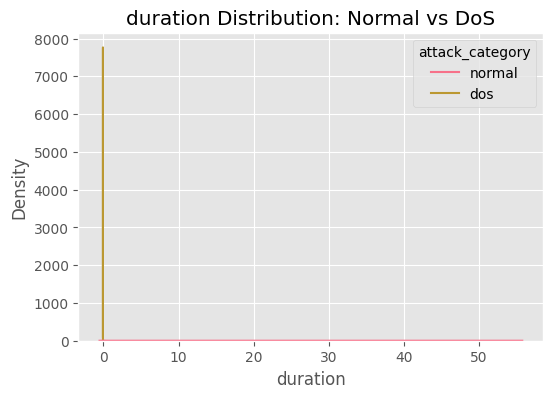

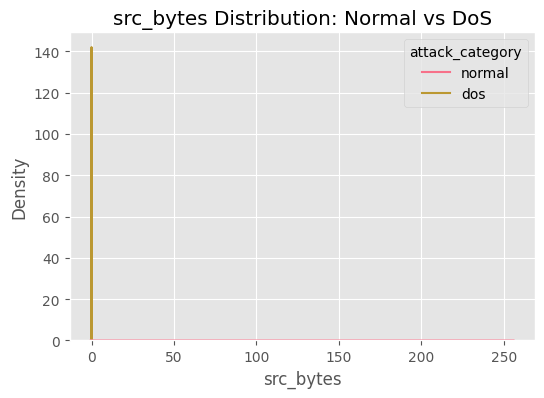

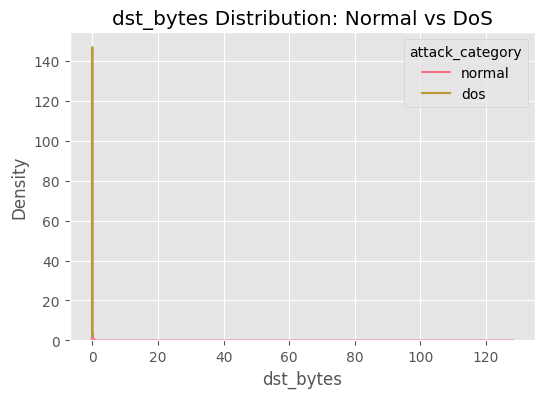

In [46]:
# ===============================
# My Exploration — Feature Distribution: Normal vs DoS
# ===============================

features = ['duration','src_bytes','dst_bytes']

for f in features:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=binary_train, x=f, hue='attack_category', common_norm=False)
    plt.title(f"{f} Distribution: Normal vs DoS")
    plt.show()

In [9]:
#should check balance or to check proportion on normal vs DOS
binary_train['attack_category'].value_counts(normalize=True)
#so abot 56% normal and 44% DOS-not heavily imbalanced,so Random Forest or similar classifiers will work well


,proportion
attack_category,
normal,0.559569
dos,0.440431


In [10]:
# Step 5: Aggregate / Roll-up by attack_category
agg_category = binary_train.groupby('attack_category')[['duration','src_bytes','dst_bytes']].mean()

print("\nAverage features per attack category:\n", agg_category)



Average features per attack category:
                   duration     src_bytes    dst_bytes
attack_category                                      
dos               0.006779   1216.122736   184.196051
normal           76.044813  16480.340672  5420.045802


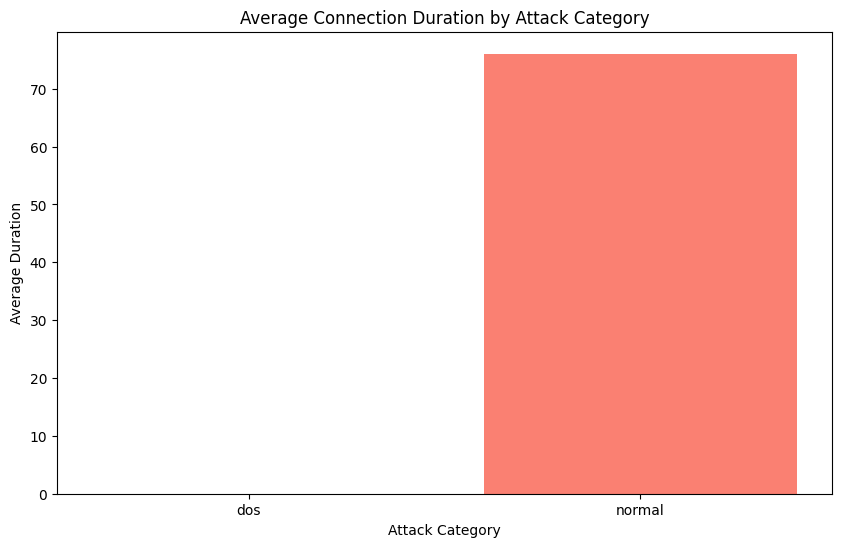

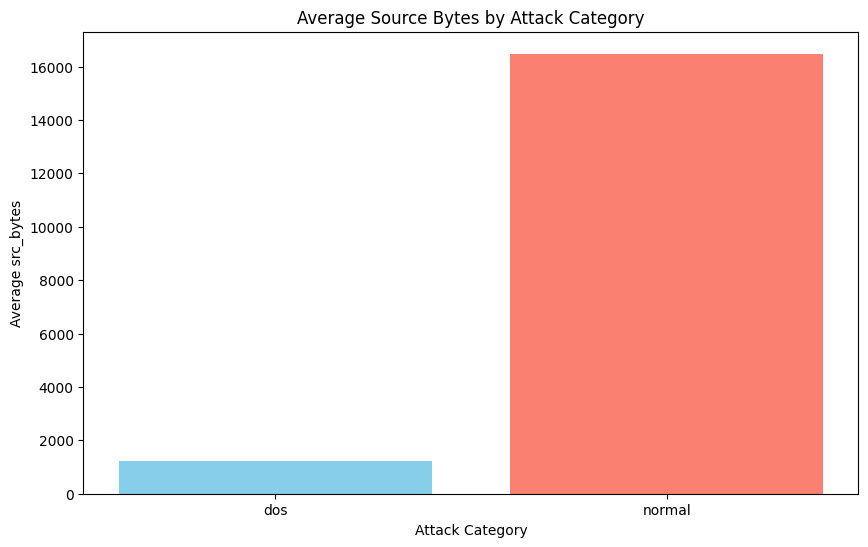

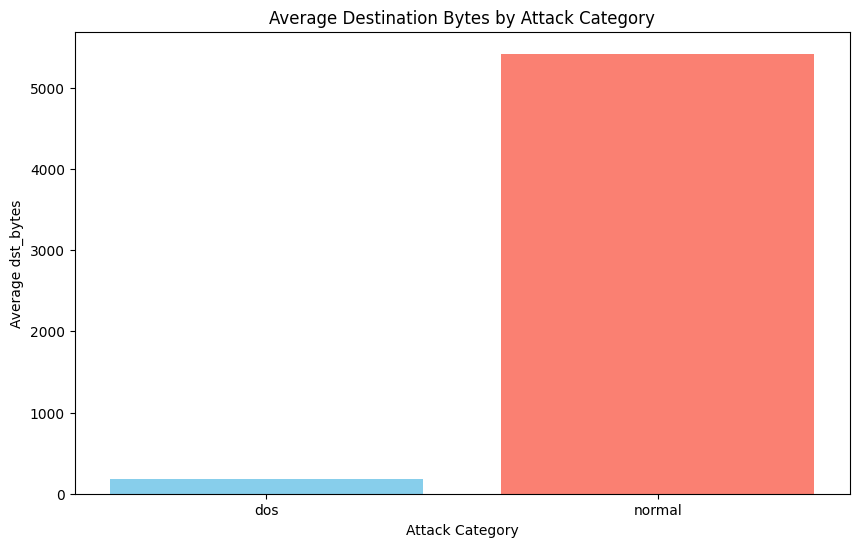

In [11]:
#Bar plot of Average features by Attack Category
import matplotlib.pyplot as plt

# Aggregate average features per attack category
agg_category = binary_train.groupby('attack_category')[['duration','src_bytes','dst_bytes']].mean()
agg_category = agg_category.reset_index()

# Plot
plt.figure(figsize=(10,6))

# Plot duration
plt.bar(agg_category['attack_category'], agg_category['duration'], color=['skyblue','salmon'])
plt.title("Average Connection Duration by Attack Category")
plt.xlabel("Attack Category")
plt.ylabel("Average Duration")
plt.show()

# Plot src_bytes
plt.figure(figsize=(10,6))
plt.bar(agg_category['attack_category'], agg_category['src_bytes'], color=['skyblue','salmon'])
plt.title("Average Source Bytes by Attack Category")
plt.xlabel("Attack Category")
plt.ylabel("Average src_bytes")
plt.show()

# Plot dst_bytes
plt.figure(figsize=(10,6))
plt.bar(agg_category['attack_category'], agg_category['dst_bytes'], color=['skyblue','salmon'])
plt.title("Average Destination Bytes by Attack Category")
plt.xlabel("Attack Category")
plt.ylabel("Average dst_bytes")
plt.show()


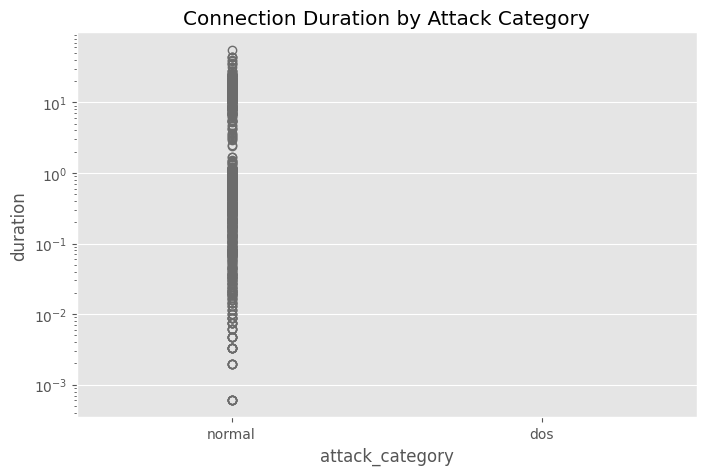

In [47]:
# ===============================
# My Exploration — Duration by Attack Category
# ===============================

plt.figure(figsize=(8,5))
sns.boxplot(x=binary_train['attack_category'], y=binary_train['duration'])
plt.yscale('log')
plt.title("Connection Duration by Attack Category")
plt.show()

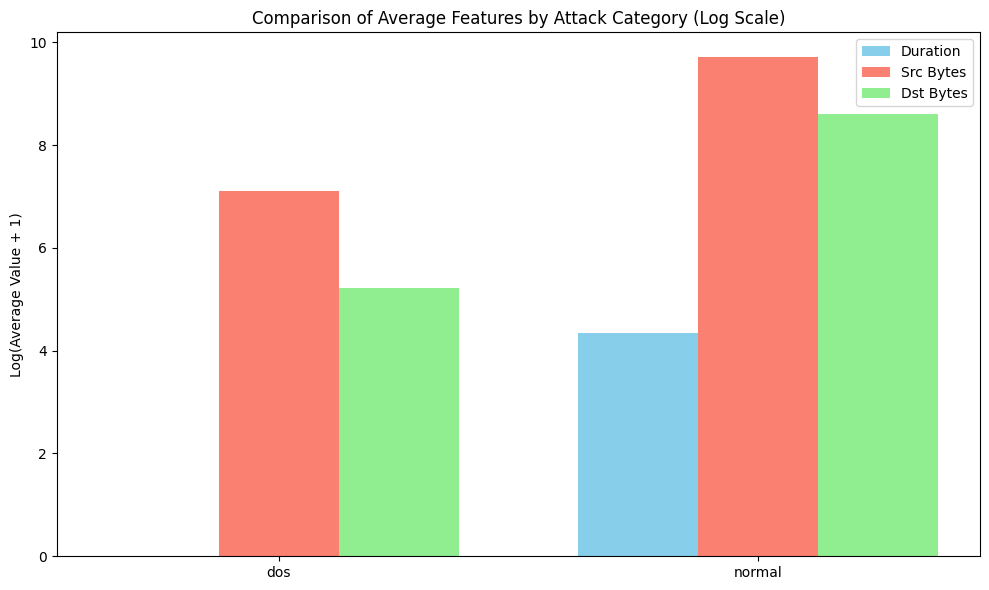

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Aggregate average features per attack category
agg_category = binary_train.groupby('attack_category')[['duration','src_bytes','dst_bytes']].mean()
agg_category = agg_category.reset_index()

# Apply log scale (log1p to handle zeros)
agg_category_log = agg_category.copy()
agg_category_log[['duration','src_bytes','dst_bytes']] = np.log1p(agg_category_log[['duration','src_bytes','dst_bytes']])

# Plot all three features in one grouped bar chart
features = ['duration','src_bytes','dst_bytes']
x = np.arange(len(agg_category_log['attack_category']))  # positions for attack categories
width = 0.25  # width of each bar

plt.figure(figsize=(10,6))

# Plot each feature
plt.bar(x - width, agg_category_log['duration'], width, label='Duration', color='skyblue')
plt.bar(x, agg_category_log['src_bytes'], width, label='Src Bytes', color='salmon')
plt.bar(x + width, agg_category_log['dst_bytes'], width, label='Dst Bytes', color='lightgreen')

# Labels and title
plt.xticks(x, agg_category_log['attack_category'])
plt.ylabel('Log(Average Value + 1)')
plt.title('Comparison of Average Features by Attack Category (Log Scale)')
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Columns to encode
categorical_cols = ['protocol_type', 'service', 'flag']

categorical_cols = ['protocol_type', 'service', 'flag']

for col in categorical_cols:
    # Combine train + test to ensure all labels are captured
    combined = pd.concat([binary_train[col], binary_test[col]], axis=0)
    codes, uniques = pd.factorize(combined)

    # Split back into train and test
    binary_train[col] = codes[:len(binary_train)]
    binary_test[col] = codes[len(binary_train):]


# Columns to normalize
numeric_cols = ['duration', 'src_bytes', 'dst_bytes']

# StandardScaler for numerical features
scaler = StandardScaler()
binary_train[numeric_cols] = scaler.fit_transform(binary_train[numeric_cols])
binary_test[numeric_cols] = scaler.transform(binary_test[numeric_cols])

# Save the processed datasets for reuse
binary_train.to_csv('derived_train_attack_category.csv', index=False)
binary_test.to_csv('derived_test_attack_category.csv', index=False)

print("Preprocessing completed. Derived datasets saved!")
print("Binary Train shape:", binary_train.shape)
print("Binary Test shape:", binary_test.shape)


/tmp/ipython-input-759/2864825287.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_train[col] = codes[:len(binary_train)]
/tmp/ipython-input-759/2864825287.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_test[col] = codes[len(binary_train):]
/tmp/ipython-input-759/2864825287.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Preprocessing completed. Derived datasets saved!
Binary Train shape: (95788, 44)
Binary Test shape: (12865, 44)


Train shape: (95788, 44)
Test shape: (12865, 44)
Number of features: 41

Classification Report:

              precision    recall  f1-score   support

         dos       1.00      1.00      1.00      5023
      normal       1.00      1.00      1.00      7842

    accuracy                           1.00     12865
   macro avg       1.00      1.00      1.00     12865
weighted avg       1.00      1.00      1.00     12865



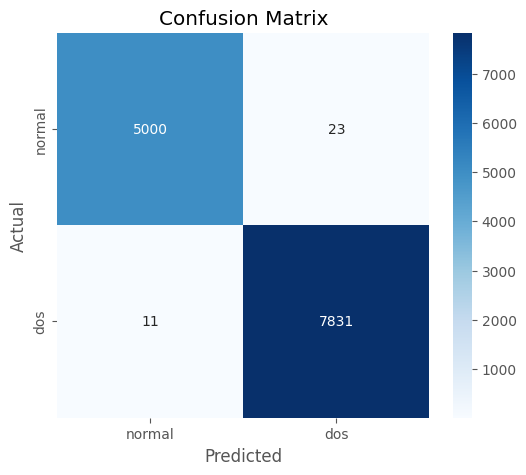

Number of misclassified samples: 34


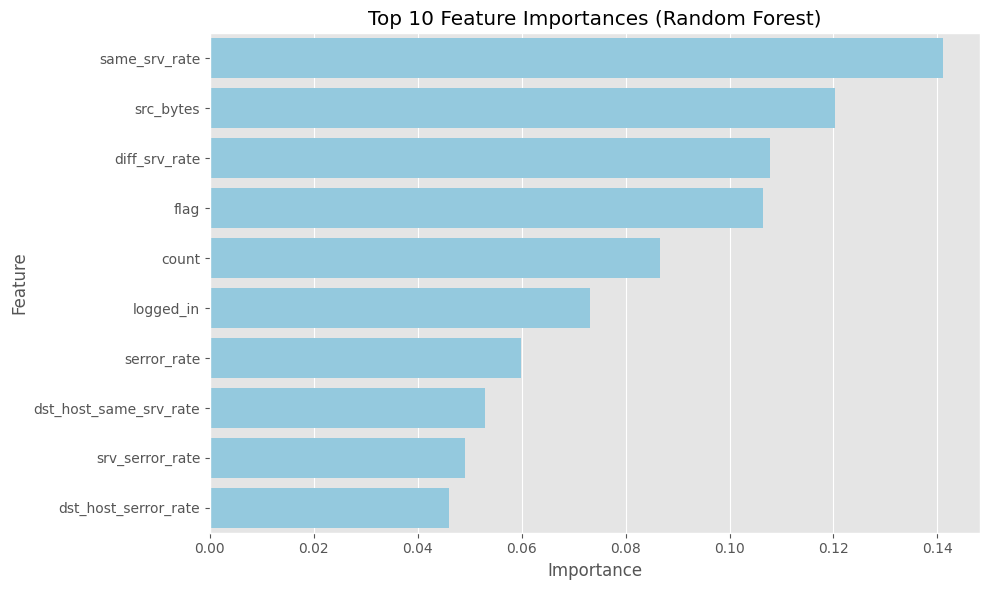

In [49]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load preprocessed datasets
train_df = pd.read_csv('derived_train_attack_category.csv')
test_df = pd.read_csv('derived_test_attack_category.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Step 2: Prepare features and target
X_train = train_df.drop(['attack_type','attack_category','level'], axis=1)
y_train = train_df['attack_category']

X_test = test_df.drop(['attack_type','attack_category','level'], axis=1)
y_test = test_df['attack_category']

print("Number of features:", X_train.shape[1])

# Step 3: Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 4: Predict on Test Data
y_pred = model.predict(X_test)

# Step 5: Evaluate Model
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal','dos'], yticklabels=['normal','dos'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ===============================
# My Exploration — Misclassified Samples
# ===============================

errors = X_test.copy()
errors['actual'] = y_test
errors['pred'] = y_pred

misclassified = errors[errors['actual'] != errors['pred']]

print("Number of misclassified samples:", len(misclassified))
misclassified.head()

# Step 6: Feature Importance

import pandas as pd

# Get importance values from model
importances = model.feature_importances_

# Create Series with feature names
feat_importances = pd.Series(importances, index=X_train.columns)

# Sort and select top 10
feat_importances = feat_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))

sns.barplot(x=feat_importances.values,
            y=feat_importances.index,
            color='skyblue')

plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [48]:
# ===============================
# My Interpretation — Important Features
# ===============================

important_features = feat_importances.index.tolist()

print("Most important features influencing attack detection:")
for f in important_features:
    print("-", f)

Most important features influencing attack detection:
- same_srv_rate
- src_bytes
- diff_srv_rate
- flag
- count
- logged_in
- serror_rate
- dst_host_same_srv_rate
- srv_serror_rate
- dst_host_serror_rate


In [15]:
def categorize_attack(x):
    if x=='normal':
        return 'normal'
    elif x in['neptune','smurf','back','teardrop','pod','land']:
        return 'dos'
    elif x in ['satan','ipsweep','portsweep','nmap']:
        return 'probe' #scanning attacks
    elif x in ['guess_passwd','ftp_write','warezclient','warezmaster','phf','multihop','imap','spy','perl']:
        return 'r2l'  #Remote to Local
    elif x in ['buffer_overflow','loadmodule','rootkit']:
        return 'u2r' #User to Root
    else:
        return 'other'

train_df['attack_category'] = train_df['attack_type'].apply(categorize_attack)
test_df['attack_category'] = test_df['attack_type'].apply(categorize_attack)
print(train_df['attack_category'].value_counts())

attack_category
normal    53600
dos       42188
Name: count, dtype: int64


In [16]:
#Definign feature Groups

categorical_features = ['protocol_type','service','flag']
binary_features = ['land','logged_in','is_host_login','is_guest_login']
#All the other numerical values

numerical_features = [col for col in columns if col not in categorical_features + binary_features +['label','difficulty_level']]

print(f"Categorical Features: {len(categorical_features)}")
print(f"Binary Features: {len(binary_features)}")
print(f"Numerical Features: {len(numerical_features)}")

print(train_df.isnull())

Categorical Features: 3
Binary Features: 4
Numerical Features: 36
       duration  protocol_type  service   flag  src_bytes  dst_bytes   land  \
0         False          False    False  False      False      False  False   
1         False          False    False  False      False      False  False   
2         False          False    False  False      False      False  False   
3         False          False    False  False      False      False  False   
4         False          False    False  False      False      False  False   
...         ...            ...      ...    ...        ...        ...    ...   
95783     False          False    False  False      False      False  False   
95784     False          False    False  False      False      False  False   
95785     False          False    False  False      False      False  False   
95786     False          False    False  False      False      False  False   
95787     False          False    False  False      False      Fa

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE, MutualInfoClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

In [18]:
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('ggplot')
sns.set_palette("husl")

# Define Column Names for NSL-KDD (Standard List)
COL_NAMES = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty_level"]

In [19]:
train_path = './data/KDDTrain+.txt'
test_path = './data/KDDTest+.txt'

# Try loading with error handling for paths
try:
    df_train = pd.read_csv(train_path, header=None, names=COL_NAMES)
    df_test = pd.read_csv(test_path, header=None, names=COL_NAMES)
    print(f"Training Data Shape: {df_train.head()}")
    print(f"Test Data Shape: {df_test.tail()}")
except FileNotFoundError:
    print("Files not found. Please check the paths. Trying absolute paths or checking local directory...")
    # Fallback to local directory if paths are different
    if os.path.exists('KDDTrain+.txt'):
        df_train = pd.read_csv('KDDTrain+.txt', header=None, names=COL_NAMES)
        df_test = pd.read_csv('KDDTest+.txt', header=None, names=COL_NAMES)


Training Data Shape:    duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0

In [20]:
categorical_features = ['protocol_type','service','flag']
binary_features = ['land','logged_in','is_host_login','is_guest_login']
#All the other numerical values

numerical_features = [col for col in COL_NAMES if col not in categorical_features + binary_features +['label','difficulty_level']]

print(f"Categorical Features: {len(categorical_features)}")
print(f"Binary Features: {len(binary_features)}")
print(f"Numerical Features: {len(numerical_features)}")

print(df_train.isnull())

Categorical Features: 3
Binary Features: 4
Numerical Features: 34
        duration  protocol_type  service   flag  src_bytes  dst_bytes   land  \
0          False          False    False  False      False      False  False   
1          False          False    False  False      False      False  False   
2          False          False    False  False      False      False  False   
3          False          False    False  False      False      False  False   
4          False          False    False  False      False      False  False   
...          ...            ...      ...    ...        ...        ...    ...   
125968     False          False    False  False      False      False  False   
125969     False          False    False  False      False      False  False   
125970     False          False    False  False      False      False  False   
125971     False          False    False  False      False      False  False   
125972     False          False    False  False      F

In [21]:
def clean_outliers_isolation_forest(df,contamination = 0.01):
    iso_df  = df[numerical_features].copy()

    clf = IsolationForest(max_samples='auto',contamination = contamination, random_state = 42)

    outliers = clf.fit_predict(iso_df)

    n_outliers = (outliers == -1).sum()
    print(f"Identifies {n_outliers} Outlilers using the Isolation forest")

    return outliers
df_train['is_outlier'] = clean_outliers_isolation_forest(df_train)

Identifies 1256 Outlilers using the Isolation forest


In [22]:
# Mapping Dictionary
attack_mapping = {
    'normal': 'normal',

    # DoS
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',

    # Probe
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',

    # R2L
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpguess': 'R2L', 'snmpgetattack': 'R2L', 'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',

    # U2R
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'ps': 'U2R', 'xterm': 'U2R', 'sqlattack': 'U2R'
}

# Apply mapping
df_train['attack_class'] = df_train['label'].map(lambda x: attack_mapping.get(x, 'other'))
df_test['attack_class'] = df_test['label'].map(lambda x: attack_mapping.get(x, 'other'))

print("Training Class Distribution:")
print(df_train['attack_class'].value_counts())

Training Class Distribution:
attack_class
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


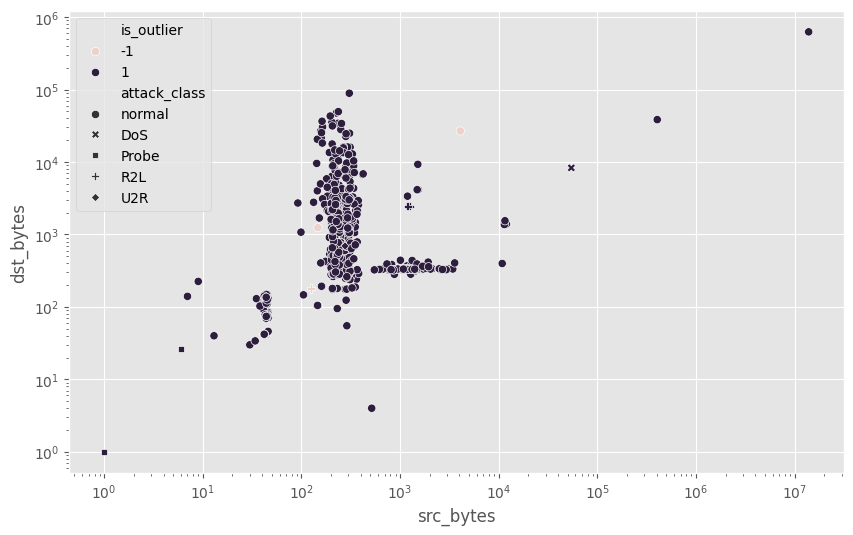

In [23]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_train[::100], x = 'src_bytes', y = 'dst_bytes', hue='is_outlier', style='attack_class')
plt.xscale('log')
plt.yscale('log')
plt.show()

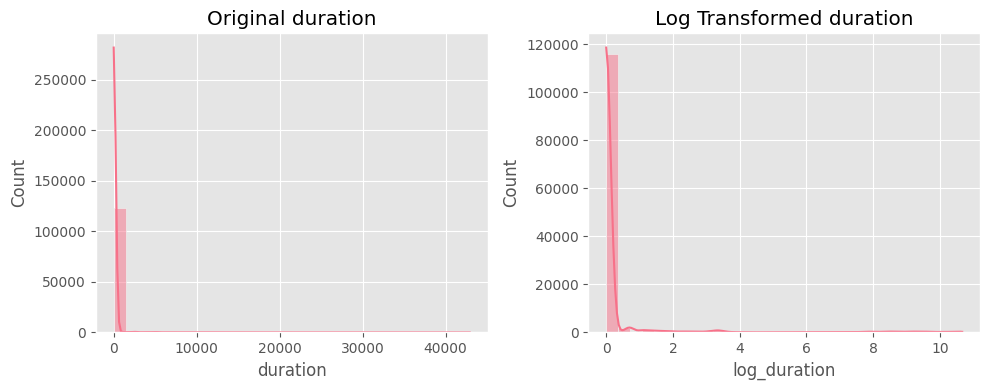

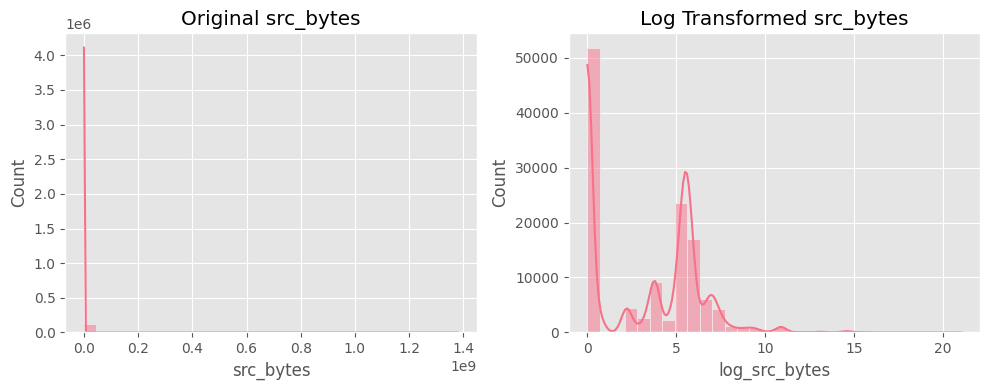

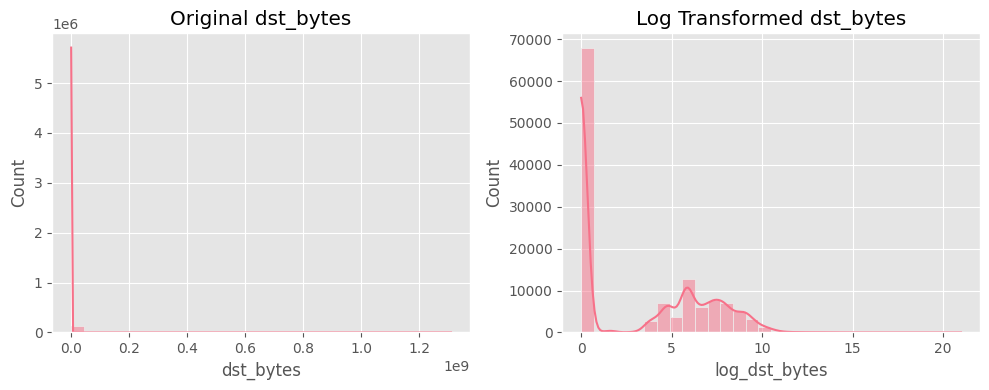

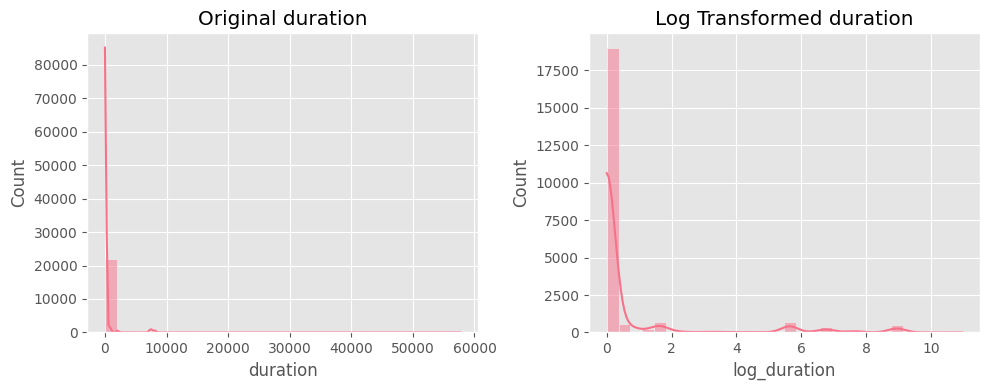

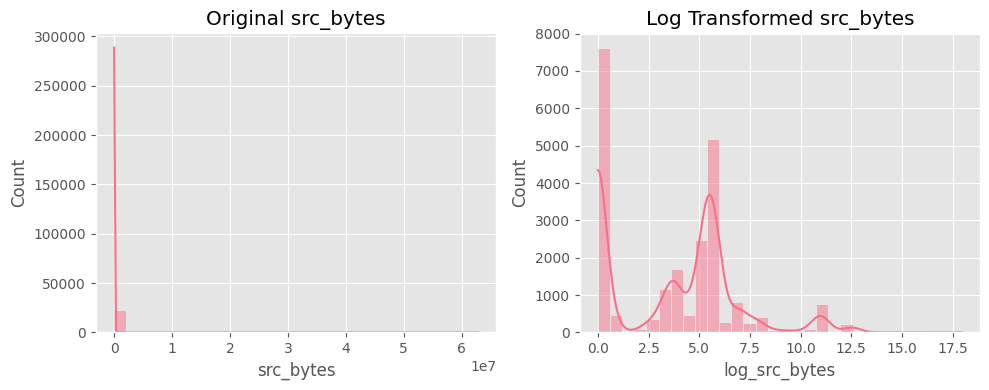

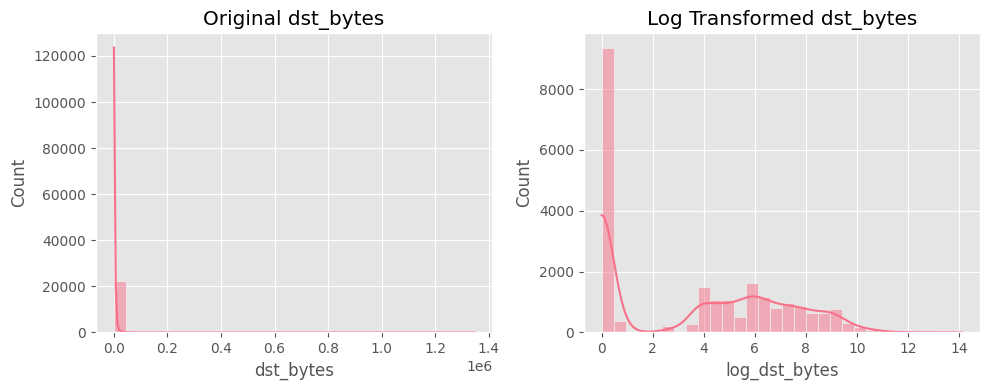

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

skewed_cols = ['duration','src_bytes','dst_bytes']

def apply_log_transform(df, cols):
    df_copy = df.copy()

    # Apply log1p to all selected columns at once
    df_copy[[f"log_{col}" for col in cols]] = np.log1p(df_copy[cols])

    # Plot comparison
    for col in cols:
        plt.figure(figsize=(10,4))

        plt.subplot(1,2,1)
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f"Original {col}")

        plt.subplot(1,2,2)
        sns.histplot(df_copy[f"log_{col}"], bins=30, kde=True)
        plt.title(f"Log Transformed {col}")

        plt.tight_layout()
        plt.show()

    return df_copy


df_train = apply_log_transform(df_train, skewed_cols)
df_test = apply_log_transform(df_test, skewed_cols)

In [25]:
def engineer_features(df):
    df_eng = df.copy()

    # 1. Total Bytes
    df_eng['total_bytes'] = df_eng['src_bytes'] + df_eng['dst_bytes']

    # 2. Byte Ratio (Handle division by zero)
    df_eng['src_bytes_ratio'] = df_eng['src_bytes'] / (df_eng['total_bytes'] + 1e-5)

    # 3. Load / Packet Rate
    # If duration is 0, we assume it's a single instantaneous event (rate = count)
    df_eng['packet_rate'] = df_eng['count'] / (df_eng['duration'] + 1e-5)

    # 4. Title: Flow Asymmetry
    df_eng['byte_diff'] = abs(df_eng['src_bytes'] - df_eng['dst_bytes'])

    # 5. Flag interactions (example: is it an error flag?)
    error_flags = ['S0', 'S1', 'S2', 'S3', 'REJ']
    df_eng['is_error_flag'] = df_eng['flag'].isin(error_flags).astype(int)

    # 6. Critical Host Interaction
    # Interaction between 'same_srv_rate' and 'dst_host_same_srv_rate'
    df_eng['same_srv_interaction'] = df_eng['same_srv_rate'] * df_eng['dst_host_same_srv_rate']

    return df_eng

df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

print("New Feature Set Head:")
print(df_train[['src_bytes_ratio', 'packet_rate', 'is_error_flag', 'same_srv_interaction']].head())

New Feature Set Head:
   src_bytes_ratio  packet_rate  is_error_flag  same_srv_interaction
0         1.000000     200000.0              0                 0.170
1         1.000000    1300000.0              0                 0.000
2         0.000000   12300000.0              1                 0.005
3         0.027668     500000.0              0                 1.000
4         0.321486    3000000.0              0                 1.000


In [26]:
def engineer_features(df):
    return df.assign(
        total_bytes = df['src_bytes'] + df['dst_bytes'],
        src_bytes_ratio = df['src_bytes'] / (df['src_bytes'] + df['dst_bytes'] + 1e-5),
        packet_rate = df['count'] / (df['duration'] + 1e-5),
        byte_diff = abs(df['src_bytes'] - df['dst_bytes']),
        is_error_flag = df['flag'].isin(['S0','S1','S2','S3','REJ']).astype(int),
        same_srv_interaction = df['same_srv_rate'] * df['dst_host_same_srv_rate']
    )

df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

print("New Feature Set Head:")
print(df_train[['src_bytes_ratio', 'packet_rate', 'is_error_flag', 'same_srv_interaction']].head())

New Feature Set Head:
   src_bytes_ratio  packet_rate  is_error_flag  same_srv_interaction
0         1.000000     200000.0              0                 0.170
1         1.000000    1300000.0              0                 0.000
2         0.000000   12300000.0              1                 0.005
3         0.027668     500000.0              0                 1.000
4         0.321486    3000000.0              0                 1.000


In [27]:
df_train['service']

,service
0,ftp_data
1,other
2,private
3,http
4,http
...,...
125968,private
125969,private
125970,smtp
125971,klogin


In [28]:
from sklearn.preprocessing import OneHotEncoder

cols_to_encode = ['protocol_type', 'flag']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on train
ohe.fit(df_train[cols_to_encode])

# Transform train & test directly
train_encoded = pd.DataFrame(
    ohe.transform(df_train[cols_to_encode]),
    columns=ohe.get_feature_names_out(cols_to_encode),
    index=df_train.index
)

test_encoded = pd.DataFrame(
    ohe.transform(df_test[cols_to_encode]),
    columns=ohe.get_feature_names_out(cols_to_encode),
    index=df_test.index
)

# Frequency encoding
freq_map = df_train['service'].value_counts(normalize=True)

df_train['service_freq'] = df_train['service'].map(freq_map)
df_test['service_freq'] = df_test['service'].map(freq_map).fillna(0)

# Final datasets
df_train_encode = pd.concat([df_train, train_encoded], axis=1)
df_test_encode = pd.concat([df_test, test_encoded], axis=1)
df_train_encode

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [29]:
print(df_train_encode.columns)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'difficulty_level', 'is_outlier',
       'attack_class', 'log_duration', 'log_src_bytes', 'log_dst_bytes',
       'total_bytes', 'src_bytes_ratio', 'packet_rate', 'byte_dif

In [30]:
print(df_test_encode.columns)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'difficulty_level', 'attack_class',
       'log_duration', 'log_src_bytes', 'log_dst_bytes', 'total_bytes',
       'src_bytes_ratio', 'packet_rate', 'byte_diff', 'is_error_

In [31]:
df_train_encode.drop(columns=['protocol_type','flag','service'],inplace = True)
df_test_encode.drop(columns=['protocol_type','flag','service'],inplace = True)

In [32]:
print(df_train_encode.shape)

df_test_encode

(125973, 66)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,12983,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,20,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0,15,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0,317,938,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0,54540,8314,0,0,0,2,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22542,0,42,42,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
#to see col are numeric
df_numeric = df_train_encode.select_dtypes(include=['int64','float64'])

In [34]:

print(df_numeric.shape)

(125973, 64)


In [35]:
#to check data types
df_train_encode.dtypes

,0
duration,int64
src_bytes,int64
dst_bytes,int64
land,int64
wrong_fragment,int64
...,...
flag_S1,float64
flag_S2,float64
flag_S3,float64
flag_SF,float64


In [36]:
df_numeric = df_train_encode.select_dtypes(include=np.number)

In [37]:
import numpy as np

df_numeric = df_train_encode.select_dtypes(include=np.number)

print("Numeric features count:", df_numeric.shape[1])

Numeric features count: 64


In [38]:
import numpy as np

corr_matrix = df_numeric.corr().abs()

In [39]:
corr_matrix = df_numeric.corr()
corr_matrix

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
duration,1.000000,0.070737,0.034878,-0.001553,-0.009866,0.003830,0.000705,0.009528,-0.064218,0.042679,...,-0.034493,-0.005336,0.034268,0.539954,-0.068182,-0.005943,-0.003411,0.001148,-0.068255,-0.005119
src_bytes,0.070737,1.000000,0.000204,-0.000109,-0.000693,-0.000059,0.000295,-0.000208,-0.003353,-0.000086,...,-0.002429,0.007609,0.178046,-0.000685,-0.004800,0.000007,-0.000229,0.000682,-0.006079,-0.000360
dst_bytes,0.034878,0.000204,1.000000,-0.000069,-0.000440,0.000248,-0.000344,0.000504,-0.002894,0.001233,...,-0.001539,-0.000537,-0.000141,0.029685,-0.003042,0.000147,0.000215,-0.000077,-0.004509,-0.000228
land,-0.001553,-0.000109,-0.000069,1.000000,-0.001261,-0.000109,-0.001340,-0.000381,-0.011402,-0.000164,...,-0.004408,-0.001579,-0.000403,-0.001972,0.022781,-0.000759,-0.000448,-0.000278,-0.017074,-0.000654
wrong_fragment,-0.009866,-0.000693,-0.000440,-0.001261,1.000000,-0.000692,-0.008508,-0.002418,-0.072418,-0.001044,...,-0.027999,-0.010027,-0.002560,-0.012526,-0.055342,-0.004824,-0.002843,-0.001765,0.073840,-0.004155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
flag_S1,-0.005943,0.000007,0.000147,-0.000759,-0.004824,-0.000417,-0.000797,0.001808,0.052719,0.016717,...,-0.016867,-0.006040,-0.001542,-0.007546,-0.033338,1.000000,-0.001712,-0.001063,-0.065329,-0.002503
flag_S2,-0.003411,-0.000229,0.000215,-0.000448,-0.002843,-0.000246,0.008963,-0.000858,0.033628,-0.000360,...,-0.009940,-0.003560,-0.000909,-0.004447,-0.019646,-0.001712,1.000000,-0.000627,-0.038499,-0.001475
flag_S3,0.001148,0.000682,-0.000077,-0.000278,-0.001765,-0.000153,-0.000190,0.017265,0.019436,-0.000129,...,-0.006172,-0.002210,-0.000564,-0.002761,-0.012199,-0.001063,-0.000627,1.000000,-0.023906,-0.000916
flag_SF,-0.068255,-0.006079,-0.004509,-0.017074,0.073840,0.006383,0.074924,0.000136,0.641738,0.007291,...,-0.379191,-0.135793,-0.034668,-0.169644,-0.749485,-0.065329,-0.038499,-0.023906,1.000000,-0.056270


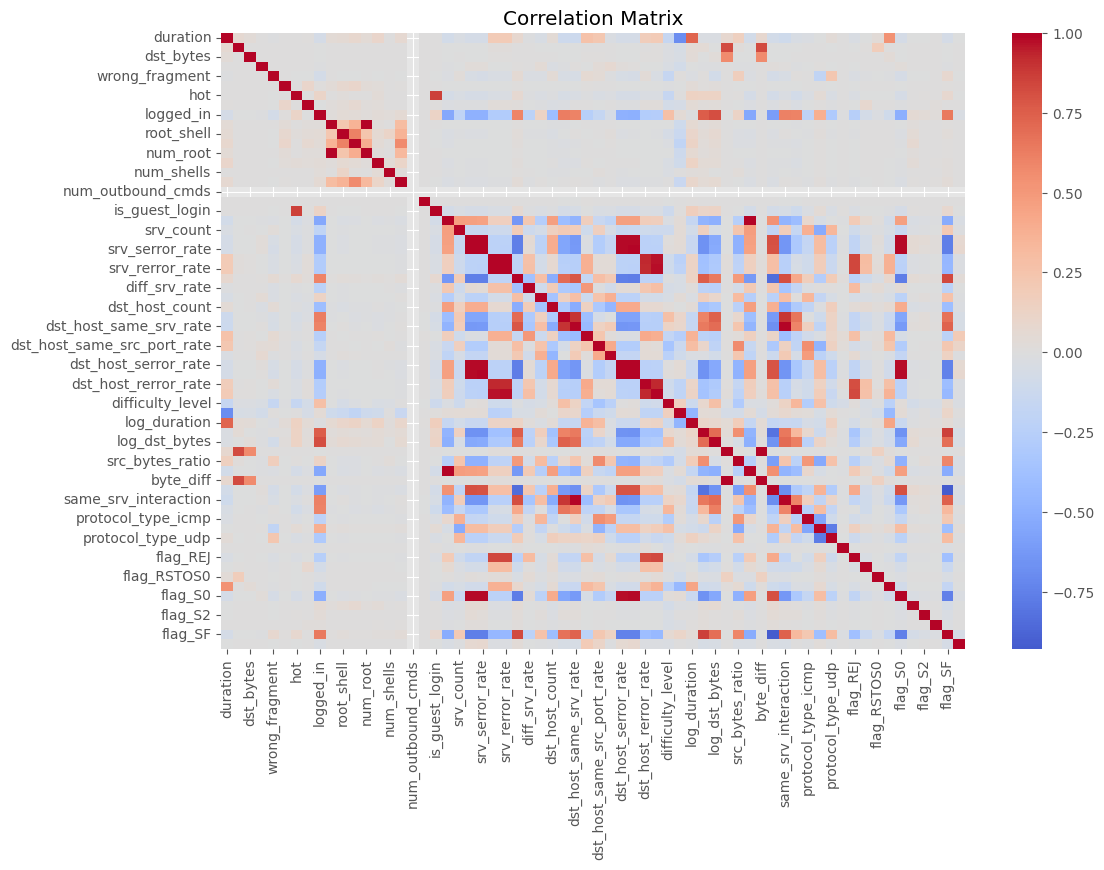

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select numeric columns
df_numeric = df_train_encode.select_dtypes(include=np.number)

# Compute correlation
corr_matrix = df_numeric.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

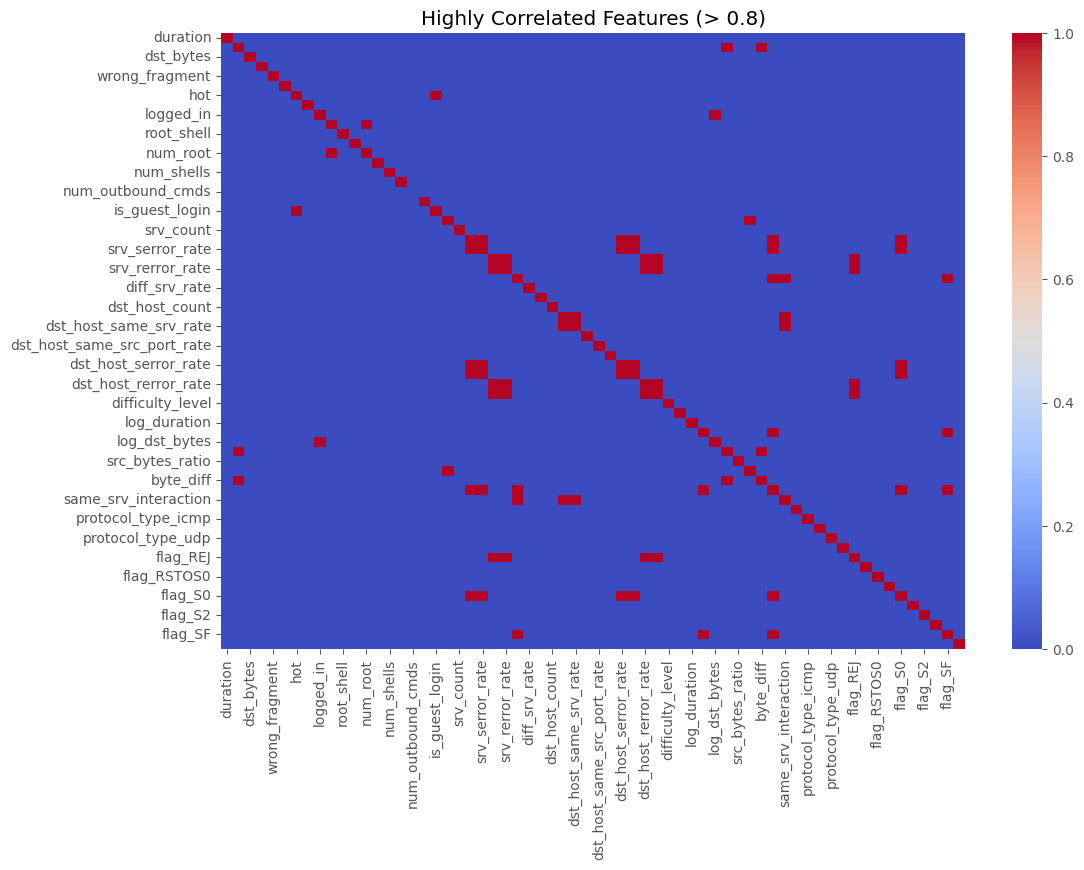

In [41]:
#strong correlation
corr_matrix = df_numeric.corr().abs()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix > 0.8, cmap='coolwarm')
plt.title("Highly Correlated Features (> 0.8)")
plt.show()

In [42]:
import numpy as np

df_numeric = df_train_encode.select_dtypes(include=np.number)

corr_matrix = df_numeric.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.9)]

print("Highly correlated features:", to_drop_corr)

df_train_clean = df_numeric.drop(columns=to_drop_corr)
df_test_clean = df_test_encode.drop(columns=to_drop_corr)

Highly correlated features: ['num_root', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'packet_rate', 'byte_diff', 'same_srv_interaction', 'flag_S0', 'flag_SF']


In [43]:
# Ensure same columns before variance selection
#df_test_clean = df_test_clean.reindex(columns=df_train_clean.columns, fill_value=0)

#selector = VarianceThreshold(threshold=0.01)
#selector.fit(df_train_clean)

#selected_cols = df_train_clean.columns[selector.get_support()]

#df_train_clean = df_train_clean[selected_cols]
#df_test_clean = df_test_clean[selected_cols]

#print("Remaining features:", len(selected_cols))

In [44]:
import numpy as np

df_numeric = df_train_encode.select_dtypes(include=np.number)

corr_matrix = df_numeric.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.95)]

print("Highly correlated features:", to_drop_corr)

df_train_clean = df_numeric.drop(columns=to_drop_corr)
df_test_clean = df_test_encode.drop(columns=to_drop_corr)

Highly correlated features: ['num_root', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate', 'packet_rate', 'byte_diff', 'same_srv_interaction', 'flag_S0']
